# 6. 프로젝트 : 주식 예측에 도전해 보자

### STEP 1 : 시계열 데이터 준비 (주식 데이터는 미리 다운)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# CSV파일 read 후 DataFrame변환
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
# print(type(df))
# df.head()

# Date를 index_col로 지정 및 컬럼 'Date, Close'만 남김 
df1 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df1 = df1.drop(df.columns[[1, 2, 3, 5, 6]], axis='columns')
# print(type(df))
# df1.head()

ts = df1['Close']
print(type(ts))
ts.head()

# ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [2]:
# 결측치 처리
# [[YOUR CODE]]
ts=ts.interpolate(method='time') # 결측치가 있다면 이를 보간,기준은 time을 선택합니다
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [9]:
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석

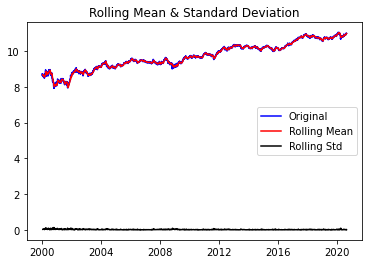

Results of Dickey-Fuller Test:
Test Statistic                   -0.685442
p-value                           0.850484
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


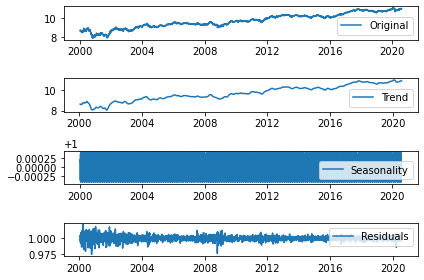

In [15]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
# Residual 안정성 확인
# [[YOUR CODE]]

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728530e+01
p-value                        5.748553e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

In [19]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

### STEP 5 : 적정 ARIMA 모수 찾기

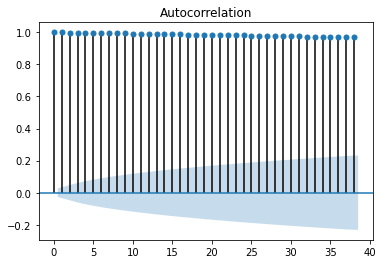

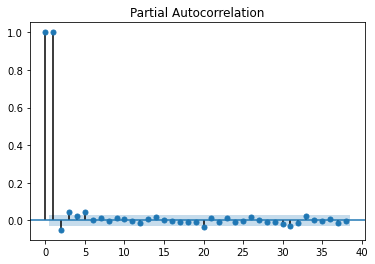

In [20]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.817652
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.584287
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


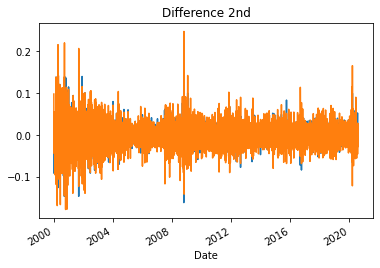

In [21]:
# 차분 안정성 확인 -> d 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# [[YOUR CODE]]

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 5 : 적정 ARIMA 모수 찾기

In [22]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21960.569
Time:                        16:34:20   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

/home/aiffel0043/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0043/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


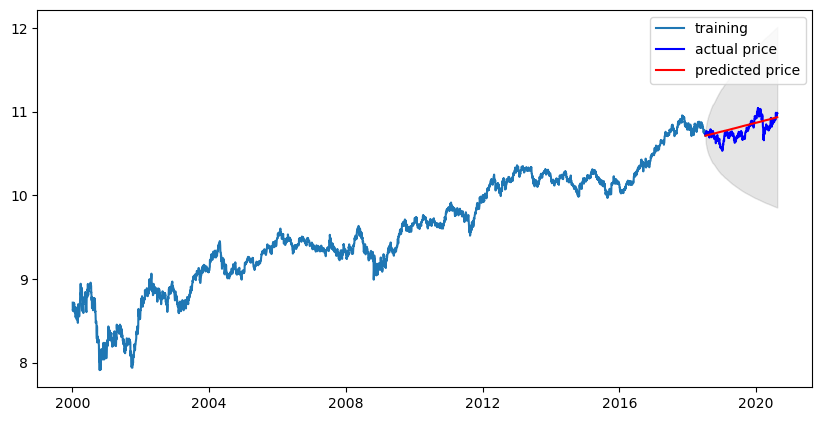

In [25]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18518938.52815272
MAE:  3590.3826801083474
RMSE:  4303.363629552204
MAPE: 7.68%


### STEP 7 : 다른 주식 종목 예측해 보기

##### STEP 7-1 : 시계열 데이터 준비 (주식 데이터는 미리 다운 - 대한항공)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/003490.KS.csv' 
df = pd.read_csv(dataset_filepath) 

df1 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df1 = df1.drop(df.columns[[1, 2, 3, 5, 6]], axis='columns')

ts = df1['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2019-08-13    23200.0
2019-08-14    22900.0
2019-08-16    22850.0
2019-08-19    22850.0
2019-08-20    23050.0
Name: Close, dtype: float64

##### STEP 2 : 각종 전처리 수행

In [30]:
ts=ts.interpolate(method='time')
ts[ts.isna()]
ts_log = np.log(ts)

##### STEP 3 : 시계열 안정성 분석

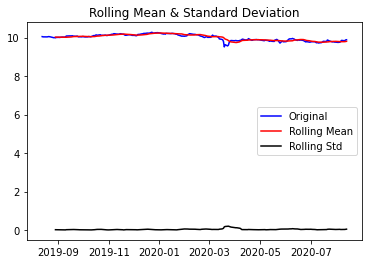

Results of Dickey-Fuller Test:
Test Statistic                  -1.680806
p-value                          0.441028
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.142370e+00
p-value                        7.914590e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


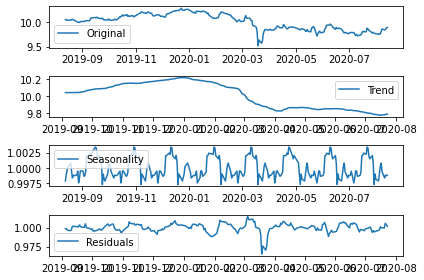

In [31]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

##### STEP 4 : 학습, 테스트 데이터셋 생성

In [32]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

##### STEP 5 : 적정 ARIMA 모수 찾기

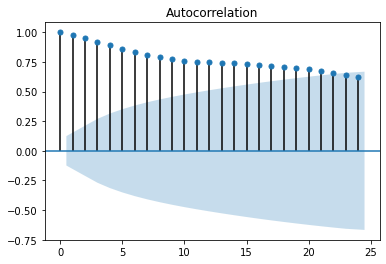

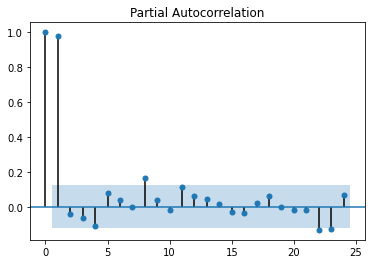

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.531810e+01
p-value                        4.099369e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.846567e+00
p-value                        5.748187e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.563997e+00
p-value                        8.543862e-14
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+

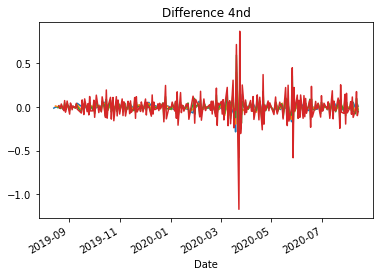

In [81]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3nd')
augmented_dickey_fuller_test(diff_3)

diff_4 = diff_3.diff(periods=1).iloc[1:]
diff_4.plot(title='Difference 4nd')
augmented_dickey_fuller_test(diff_4)

Results of Dickey-Fuller Test:
Test Statistic                -1.531810e+01
p-value                        4.099369e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.846567e+00
p-value                        5.748187e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.563997e+00
p-value                        8.543862e-14
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+

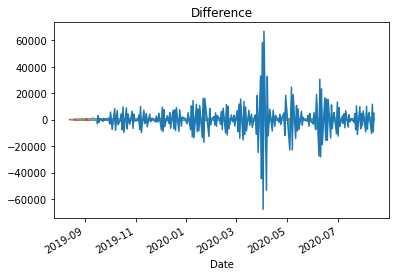

In [92]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

a= diff_1
n = 20
for i in range(n):
    a =a.diff(periods=1).iloc[1:]
    if i <= (n-1):
        a.plot(title= 'Difference')
        augmented_dickey_fuller_test(a)

In [93]:
#차분을 할 경우  12번째에서 P-value값이 최소

##### STEP 6 : ARIMA 모델 훈련과 테스트

In [94]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 12))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel0043/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0043/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                ARIMA(1, 1, 12)   Log Likelihood                 429.532
Method:                       css-mle   S.D. of innovations              0.035
Date:                Thu, 13 Aug 2020   AIC                           -829.064
Time:                        18:11:44   BIC                           -777.956
Sample:                             1   HQIC                          -808.432
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013      0.001     -0.944      0.345      -0.004       0.001
ar.L1.D.Close      0.2311      0.428      0.540      0.589      -0.607       1.069
ma.L1.D.Close     -0.2360      0.423

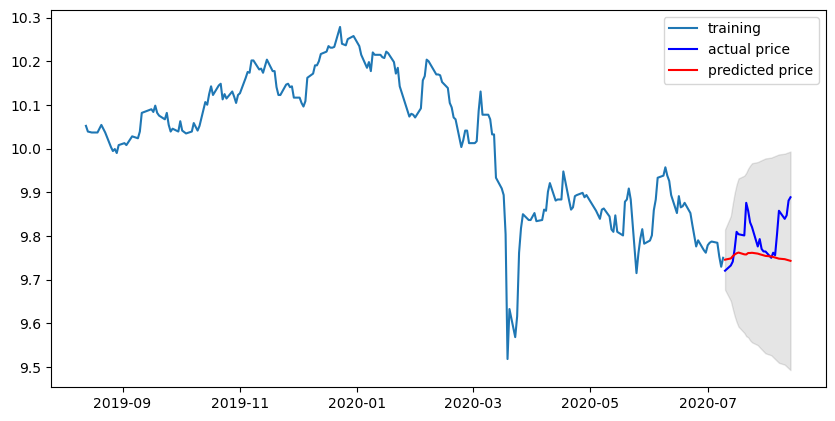

In [95]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1506702.5894200164
MAE:  924.8961171494167
RMSE:  1227.4781421353362
MAPE: 4.93%
